# Autoencoding AIS data
### This notebook creates an autoencoding model: a neural network whose accuracy is measured by how well it recreates compressed data. It is the beginning of research into applying this unsupervised machine learning method to this data set.

The model's trained state is saved in `autoencoder_state.txt` so it can be used to test its accuracy and evaluate other data sets. Changing values of constants (learning rate, number of epochs, batch size) will change the model. For future implementation, the saved state should have a timestamped name -- the better to evaluate multiple models.

Also created: a file with aggregated data and all of the calculated losses, `ais_autoencode_all_losses.csv`, and another with the "largest" losses (determined in this exploratory case by visual inspection of the loss histogram), `ais_autoencode_large_losses.csv`.

Finally: TSNE is a clustering algorithm that projects multidimensional features to a more human-comprehensible 2D or 3D space. In this case, TSNE was applied to the aggregated data to create two more features, `x` and `y` for graphing. This file is `aggs_tsne.csv`.

#### Steps to create the autoencoding model for AIS data...
1. read in the data
2. rename columns as necessary
3. preprocess data
4. create TabularDataset from normed data (identify categorical data to be converted to numerical)
5. choose constants (epochs, learning rate, batch size)
6. load data with DataLoader: include dataset, batch size, etc.
7. instantiate Autoencoder
8. define distance metric
9. define optimizer
10. convert data to floats
11. Autoencoder.train()
12. Train over the number of epochs, see how data separates itself out. See Autoencoder.eval()
13. Identify elements in batches in each clump.
14. What features stand out in those batches?
15. Visualize with TSNE: Add x, y values to data


In [ ]:

from autoencoder import TabularDataset, Autoencoder

from fastai.tabular.all import *
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch
from typing import List
import glob
import os
import uuid

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [ ]:
data = pd.read_csv('ais.tsv', sep='\t')
data['dt'] = pd.to_datetime(data['dt'], format='%Y-%m-%dT%H:%M:%S')

In [ ]:
agg_dictionary = {
	'sog': ['mean', 'min', 'max', 'std'],
	'dt': 'count', 
	'length': 'mean',
	'width': 'mean', 
	'draft': 'mean'
}

In [ ]:
aggs = data.groupby(['mmsi', pd.Grouper(key='dt', freq='H'), 'status', 'vesseltype']).agg(agg_dictionary)
aggs.reset_index(inplace=True)
aggs.head()

mmsi                  dt                  status vesseltype     sog  \
                                                                      mean   
0  43676060 2015-01-09 16:00:00  under way using engine    0.00000 8.82593   
1  43676060 2015-01-09 17:00:00  under way using engine    0.00000 6.51915   
2  43676060 2015-01-09 18:00:00  under way using engine    0.00000 4.28936   
3  43676060 2015-01-09 19:00:00  under way using engine    0.00000 8.43636   
4  43676060 2015-01-09 20:00:00  under way using engine    0.00000 8.36316   

                             dt   length   width   draft  
      min     max     std count     mean    mean    mean  
0 8.60000 9.00000 0.11633    27 32.00000 9.00000 4.00000  
1 0.00000 8.70000 3.40042    47 32.00000 9.00000 4.00000  
2 0.00000 8.80000 4.20922    47 32.00000 9.00000 4.00000  
3 8.10000 8.60000 0.16857    44 32.00000 9.00000 4.00000  
4 8.10000 8.50000 0.07136    38 32.00000 9.00000 4.00000

In [ ]:
aggs.columns = ['_'.join(col).strip() for col in aggs.columns.values]

In [ ]:
aggs.rename(columns={'mmsi_':'mmsi', 'dt_':'dt', 'status_': 'status', 'vesseltype_':'vesseltype', 
                     'dt_count':'count', 'length_mean':'length', 'width_mean':'width', 'draft_mean':'draft'}, 
            inplace=True)

In [ ]:
aggs['vesseltype'] = aggs['vesseltype'].astype(int)

In [ ]:
aggs.head()

,mmsi,dt,status,vesseltype,sog_mean,sog_min,sog_max,sog_std,count,length,width,draft
0,43676060,2015-01-09 16:00:00,under way using engine,0,8.82593,8.60000,9.00000,0.11633,27,32.00000,9.00000,4.00000
1,43676060,2015-01-09 17:00:00,under way using engine,0,6.51915,0.00000,8.70000,3.40042,47,32.00000,9.00000,4.00000
2,43676060,2015-01-09 18:00:00,under way using engine,0,4.28936,0.00000,8.80000,4.20922,47,32.00000,9.00000,4.00000
3,43676060,2015-01-09 19:00:00,under way using engine,0,8.43636,8.10000,8.60000,0.16857,44,32.00000,9.00000,4.00000
4,43676060,2015-01-09 20:00:00,under way using engine,0,8.36316,8.10000,8.50000,0.07136,38,32.00000,9.00000,4.00000


In [ ]:
aggs.fillna(0, inplace=True)

In [ ]:
aggs.shape

(207257, 12)

In [ ]:
aggs['vesseltype'].unique()

array([   0,   30,   72, 1004,   70,   79,   71, 1024, 1003, 1020, 1001,
       1025, 1002, 1012, 1018,   74,   47,    4, 1005,   33, 1010, 1013,
        110,   80,   84, 1022,    7])

Create a sparse matrix for the vessel types: fishing, argo, tanker, tugtow, na, no idea...

In [ ]:
vessel_dictionary = {
    0:'na',
    4:'other', 7:'other', 33:'other', 47:'other', 110:'other', 
    1005:'other', 1010:'other', 1018:'other', 1020:'other', 1022:'other', 
    30:'fishing', 1001:'fishing', 1002:'fishing', 
    70:'cargo', 71:'cargo', 72:'cargo', 74:'cargo', 79:'cargo', 1003:'cargo', 1004:'cargo',
    80:'tanker', 84:'tanker', 1024:'tanker',
    1012:'passenger', 1013:'passenger',
    1025:'tugtow'
}

In [ ]:
aggs['vessel'] = aggs['vesseltype'].map(vessel_dictionary)

In [ ]:
aggs[2000:2010]

,mmsi,dt,status,vesseltype,sog_mean,sog_min,sog_max,sog_std,count,length,width,draft,vessel
2000,228348900,2015-01-28 12:00:00,under way using engine,1004,20.06250,19.60000,20.50000,0.24977,56,349.06000,42.80000,15.02000,cargo
2001,228348900,2015-01-28 13:00:00,under way using engine,1004,19.87679,19.50000,20.20000,0.20449,56,349.06000,42.80000,15.02000,cargo
2002,228348900,2015-01-28 14:00:00,under way using engine,1004,20.02609,19.70000,20.30000,0.13888,23,349.06000,42.80000,15.02000,cargo
2003,228353600,2015-01-29 22:00:00,under way using engine,1004,17.22000,16.90000,17.50000,0.22804,5,334.00000,42.80000,14.50000,cargo
2004,228353600,2015-01-29 23:00:00,under way using engine,1004,17.08667,16.50000,17.50000,0.21996,15,334.00000,42.80000,14.50000,cargo
2005,228353600,2015-01-30 00:00:00,under way using engine,1004,16.37143,16.10000,16.90000,0.28702,7,334.00000,42.80000,14.50000,cargo
2006,228353600,2015-01-30 01:00:00,under way using engine,1004,16.00000,15.70000,16.30000,0.28284,5,334.00000,42.80000,14.50000,cargo
2007,228353600,2015-01-30 05:00:00,under way using engine,1004,16.17500,15.80000,16.70000,0.45000,4,334.00000,42.80000,14.50000,cargo
2008,228353600,2015-01-30 06:00:00,under way using engine,1004,16.79130,15.90000,17.80000,0.58188,46,334.00000,42.80000,14.50000,cargo
2009,228353600,2015-01-30 07:00:00,under way using engine,1004,16.01636,15.60000,16.40000,0.20884,55,334.00000,42.80000,14.50000,cargo


In [ ]:
BYTES_TO_MB_DIV = 0.000001
def print_memory_usage_of_data_frame(df):
    mem = round(df.memory_usage().sum() * BYTES_TO_MB_DIV, 3) 
    print("Memory usage is " + str(mem) + " MB")

In [ ]:
print_memory_usage_of_data_frame(aggs)

Memory usage is 21.555 MB


In [ ]:
one_hot = pd.get_dummies(aggs, columns=['status', 'vessel'])
one_hot.head()

,mmsi,dt,vesseltype,sog_mean,sog_min,sog_max,sog_std,count,length,width,draft,status_at anchor,status_engaged in fishing,status_moored,status_not under command,status_reserved for future use (10),status_restricted maneuverability,status_undefined,status_under way sailing,status_under way using engine,vessel_cargo,vessel_fishing,vessel_na,vessel_other,vessel_passenger,vessel_tanker,vessel_tugtow
0,43676060,2015-01-09 16:00:00,0,8.82593,8.60000,9.00000,0.11633,27,32.00000,9.00000,4.00000,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,43676060,2015-01-09 17:00:00,0,6.51915,0.00000,8.70000,3.40042,47,32.00000,9.00000,4.00000,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2,43676060,2015-01-09 18:00:00,0,4.28936,0.00000,8.80000,4.20922,47,32.00000,9.00000,4.00000,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,43676060,2015-01-09 19:00:00,0,8.43636,8.10000,8.60000,0.16857,44,32.00000,9.00000,4.00000,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
4,43676060,2015-01-09 20:00:00,0,8.36316,8.10000,8.50000,0.07136,38,32.00000,9.00000,4.00000,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [ ]:
print_memory_usage_of_data_frame(one_hot)

Memory usage is 21.555 MB


Just interesting to note that the one-hot encoding here did not save any space in this case.

In [ ]:
one_hot.shape

(207257, 27)

In [ ]:
categorical = ['mmsi', 'dt']
continuous = list(set(one_hot.columns)-set(categorical))
continuous

['draft',
 'sog_max',
 'sog_mean',
 'status_moored',
 'status_at anchor',
 'vessel_fishing',
 'sog_std',
 'length',
 'status_engaged in fishing',
 'sog_min',
 'status_undefined',
 'vessel_cargo',
 'status_not under command',
 'count',
 'status_reserved for future use (10)',
 'status_restricted maneuverability',
 'status_under way using engine',
 'vesseltype',
 'status_under way sailing',
 'vessel_passenger',
 'vessel_tugtow',
 'vessel_other',
 'width',
 'vessel_tanker',
 'vessel_na']

### Not sure normalizing the one-hot encoded part of the data is useful.
Also! Categorifying mmsi ... there should be a reverse-lookup dictionary to get it back later. Deal with this in the future.

In [ ]:
to = TabularPandas(one_hot, procs=[Categorify, Normalize], cat_names=categorical, cont_names=continuous)

In [ ]:
type(to)

fastai.tabular.core.TabularPandas

In [ ]:
to.xs.iloc[:2]

,mmsi,dt,draft,sog_max,sog_mean,status_moored,status_at anchor,vessel_fishing,sog_std,length,status_engaged in fishing,sog_min,status_undefined,vessel_cargo,status_not under command,count,status_reserved for future use (10),status_restricted maneuverability,status_under way using engine,vesseltype,status_under way sailing,vessel_passenger,vessel_tugtow,vessel_other,width,vessel_tanker,vessel_na
0,1,209,0.22725,1.04092,1.19560,-0.28562,-0.19603,-1.57311,-0.26734,-0.46603,-0.34151,1.30228,-0.41790,-0.40997,-0.04320,-0.85023,-0.03926,-0.03348,0.81377,-2.79489,-0.17070,-0.04873,-0.23939,-0.20350,-0.39686,-0.07177,4.75001
1,1,210,0.22725,0.98316,0.71988,-0.28562,-0.19603,-1.57311,4.18455,-0.46603,-0.34151,-0.55239,-0.41790,-0.40997,-0.04320,0.31321,-0.03926,-0.03348,0.81377,-2.79489,-0.17070,-0.04873,-0.23939,-0.20350,-0.39686,-0.07177,4.75001


In [ ]:
to.xs.shape

(207257, 27)

### Must use a Dataset and not simply a dataframe for the DataLoader

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 5

In [ ]:
dataset = TabularDataset(to.xs)

In [ ]:
dls = DataLoader(dataset, batch_size=BATCH_SIZE)

In [ ]:
otto = Autoencoder(to.xs.shape[1])

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(otto.parameters(), lr=LEARNING_RATE)

Note that the cell below was interrupted during its run after accidentally being restarted.

In [ ]:
otto.float()
otto.train()
train_loss = []

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for batch in dls:     
        # clear the optimizer of previous gradients
        optimizer.zero_grad()
        # forward ---------------------------------------------
        output= otto(batch[1]) #batch is a list of three vectors: 
                # [y, cont_X, and cat_X]. We already converted categorical to continuous, so pass in batch[1]
        loss = criterion(output, batch[1])
        # backward --------------------------------------------
        loss.backward()
        optimizer.step()
        # keep a running total of loss for the batches in this epoch
        running_loss += loss.item()
    # log
    lossb = running_loss / len(dls)
    train_loss.append(lossb)
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, NUM_EPOCHS, loss.data), lossb)
    
otto.eval()

loss tensor(17.6778, grad_fn=<MseLossBackward>)
loss tensor(32.1896, grad_fn=<MseLossBackward>)
loss tensor(67.3849, grad_fn=<MseLossBackward>)
loss tensor(88.3202, grad_fn=<MseLossBackward>)
loss tensor(83.8947, grad_fn=<MseLossBackward>)
loss tensor(54.3650, grad_fn=<MseLossBackward>)
loss tensor(28.2253, grad_fn=<MseLossBackward>)
loss tensor(7.7455, grad_fn=<MseLossBackward>)
loss tensor(3.3729, grad_fn=<MseLossBackward>)
loss tensor(10.6338, grad_fn=<MseLossBackward>)
loss tensor(16.0843, grad_fn=<MseLossBackward>)
loss tensor(19.8149, grad_fn=<MseLossBackward>)
loss tensor(23.2630, grad_fn=<MseLossBackward>)
loss tensor(39.2549, grad_fn=<MseLossBackward>)
loss tensor(62.7368, grad_fn=<MseLossBackward>)
loss tensor(39.0340, grad_fn=<MseLossBackward>)
loss tensor(39.4475, grad_fn=<MseLossBackward>)
loss tensor(37.2279, grad_fn=<MseLossBackward>)
loss tensor(62.9386, grad_fn=<MseLossBackward>)
loss tensor(33.1338, grad_fn=<MseLossBackward>)
loss tensor(96.0816, grad_fn=<MseLossBackw

loss tensor(1.4027, grad_fn=<MseLossBackward>)
loss tensor(0.2657, grad_fn=<MseLossBackward>)
loss tensor(0.5654, grad_fn=<MseLossBackward>)
loss tensor(1.5947, grad_fn=<MseLossBackward>)
loss tensor(2.4092, grad_fn=<MseLossBackward>)
loss tensor(4.6361, grad_fn=<MseLossBackward>)
loss tensor(5.0324, grad_fn=<MseLossBackward>)
loss tensor(3.7618, grad_fn=<MseLossBackward>)
loss tensor(1.8791, grad_fn=<MseLossBackward>)
loss tensor(1.8348, grad_fn=<MseLossBackward>)
loss tensor(2.0761, grad_fn=<MseLossBackward>)
loss tensor(1.7952, grad_fn=<MseLossBackward>)
loss tensor(1.7092, grad_fn=<MseLossBackward>)
loss tensor(2.1893, grad_fn=<MseLossBackward>)
loss tensor(1.3131, grad_fn=<MseLossBackward>)
loss tensor(0.8738, grad_fn=<MseLossBackward>)
loss tensor(0.9329, grad_fn=<MseLossBackward>)
loss tensor(1.2148, grad_fn=<MseLossBackward>)
loss tensor(1.8326, grad_fn=<MseLossBackward>)
loss tensor(2.1589, grad_fn=<MseLossBackward>)
loss tensor(2.4042, grad_fn=<MseLossBackward>)
loss tensor(1

loss tensor(2.0176, grad_fn=<MseLossBackward>)
loss tensor(1.7291, grad_fn=<MseLossBackward>)
loss tensor(1.3025, grad_fn=<MseLossBackward>)
loss tensor(1.4375, grad_fn=<MseLossBackward>)
loss tensor(3.0908, grad_fn=<MseLossBackward>)
loss tensor(1.8950, grad_fn=<MseLossBackward>)
loss tensor(1.2775, grad_fn=<MseLossBackward>)
loss tensor(1.0689, grad_fn=<MseLossBackward>)
loss tensor(1.6567, grad_fn=<MseLossBackward>)
loss tensor(2.2601, grad_fn=<MseLossBackward>)
loss tensor(2.6423, grad_fn=<MseLossBackward>)
loss tensor(2.9771, grad_fn=<MseLossBackward>)
loss tensor(3.1652, grad_fn=<MseLossBackward>)
loss tensor(3.5600, grad_fn=<MseLossBackward>)
loss tensor(2.3958, grad_fn=<MseLossBackward>)
loss tensor(3.2187, grad_fn=<MseLossBackward>)
loss tensor(3.3258, grad_fn=<MseLossBackward>)
loss tensor(3.0463, grad_fn=<MseLossBackward>)
loss tensor(2.7611, grad_fn=<MseLossBackward>)
loss tensor(2.2598, grad_fn=<MseLossBackward>)
loss tensor(1.7422, grad_fn=<MseLossBackward>)
loss tensor(1

loss tensor(1.9825, grad_fn=<MseLossBackward>)
loss tensor(1.0022, grad_fn=<MseLossBackward>)
loss tensor(1.9028, grad_fn=<MseLossBackward>)
loss tensor(2.3831, grad_fn=<MseLossBackward>)
loss tensor(3.1532, grad_fn=<MseLossBackward>)
loss tensor(3.2697, grad_fn=<MseLossBackward>)
loss tensor(3.6070, grad_fn=<MseLossBackward>)
loss tensor(3.5331, grad_fn=<MseLossBackward>)
loss tensor(3.4245, grad_fn=<MseLossBackward>)
loss tensor(5.4490, grad_fn=<MseLossBackward>)
loss tensor(4.0612, grad_fn=<MseLossBackward>)
loss tensor(3.1828, grad_fn=<MseLossBackward>)
loss tensor(2.5227, grad_fn=<MseLossBackward>)
loss tensor(2.2672, grad_fn=<MseLossBackward>)
loss tensor(2.0807, grad_fn=<MseLossBackward>)
loss tensor(1.9239, grad_fn=<MseLossBackward>)
loss tensor(2.3147, grad_fn=<MseLossBackward>)
loss tensor(2.5339, grad_fn=<MseLossBackward>)
loss tensor(2.1424, grad_fn=<MseLossBackward>)
loss tensor(1.9472, grad_fn=<MseLossBackward>)
loss tensor(1.7161, grad_fn=<MseLossBackward>)
loss tensor(1

loss tensor(4.5237, grad_fn=<MseLossBackward>)
loss tensor(3.4615, grad_fn=<MseLossBackward>)
loss tensor(1.7312, grad_fn=<MseLossBackward>)
loss tensor(6.9254, grad_fn=<MseLossBackward>)
loss tensor(2.7572, grad_fn=<MseLossBackward>)
loss tensor(3.1158, grad_fn=<MseLossBackward>)
loss tensor(4.5948, grad_fn=<MseLossBackward>)
loss tensor(3.5639, grad_fn=<MseLossBackward>)
loss tensor(4.6986, grad_fn=<MseLossBackward>)
loss tensor(2.5481, grad_fn=<MseLossBackward>)
loss tensor(1.8126, grad_fn=<MseLossBackward>)
loss tensor(1.8749, grad_fn=<MseLossBackward>)
loss tensor(1.9027, grad_fn=<MseLossBackward>)
loss tensor(7.2880, grad_fn=<MseLossBackward>)
loss tensor(11.2182, grad_fn=<MseLossBackward>)
loss tensor(3.0821, grad_fn=<MseLossBackward>)
loss tensor(2.8613, grad_fn=<MseLossBackward>)
loss tensor(2.9026, grad_fn=<MseLossBackward>)
loss tensor(2.7746, grad_fn=<MseLossBackward>)
loss tensor(2.5725, grad_fn=<MseLossBackward>)
loss tensor(2.3315, grad_fn=<MseLossBackward>)
loss tensor(

loss tensor(0.4497, grad_fn=<MseLossBackward>)
loss tensor(0.3954, grad_fn=<MseLossBackward>)
loss tensor(0.4306, grad_fn=<MseLossBackward>)
loss tensor(0.4376, grad_fn=<MseLossBackward>)
loss tensor(0.5091, grad_fn=<MseLossBackward>)
loss tensor(1.0288, grad_fn=<MseLossBackward>)
loss tensor(0.6958, grad_fn=<MseLossBackward>)
loss tensor(0.2820, grad_fn=<MseLossBackward>)
loss tensor(4.7487, grad_fn=<MseLossBackward>)
loss tensor(6.4462, grad_fn=<MseLossBackward>)
loss tensor(5.3246, grad_fn=<MseLossBackward>)
loss tensor(3.1756, grad_fn=<MseLossBackward>)
loss tensor(1.7986, grad_fn=<MseLossBackward>)
loss tensor(0.8751, grad_fn=<MseLossBackward>)
loss tensor(0.5158, grad_fn=<MseLossBackward>)
loss tensor(0.6104, grad_fn=<MseLossBackward>)
loss tensor(1.0434, grad_fn=<MseLossBackward>)
loss tensor(1.2436, grad_fn=<MseLossBackward>)
loss tensor(1.5968, grad_fn=<MseLossBackward>)
loss tensor(1.1986, grad_fn=<MseLossBackward>)
loss tensor(0.5053, grad_fn=<MseLossBackward>)
loss tensor(0

loss tensor(2.8148, grad_fn=<MseLossBackward>)
loss tensor(2.7248, grad_fn=<MseLossBackward>)
loss tensor(2.5183, grad_fn=<MseLossBackward>)
loss tensor(2.1404, grad_fn=<MseLossBackward>)
loss tensor(1.9395, grad_fn=<MseLossBackward>)
loss tensor(1.3914, grad_fn=<MseLossBackward>)
loss tensor(0.5740, grad_fn=<MseLossBackward>)
loss tensor(0.5212, grad_fn=<MseLossBackward>)
loss tensor(0.6366, grad_fn=<MseLossBackward>)
loss tensor(0.6615, grad_fn=<MseLossBackward>)
loss tensor(0.2828, grad_fn=<MseLossBackward>)
loss tensor(0.5774, grad_fn=<MseLossBackward>)
loss tensor(0.7284, grad_fn=<MseLossBackward>)
loss tensor(0.3166, grad_fn=<MseLossBackward>)
loss tensor(0.3526, grad_fn=<MseLossBackward>)
loss tensor(5.2973, grad_fn=<MseLossBackward>)
loss tensor(6.6979, grad_fn=<MseLossBackward>)
loss tensor(3.8777, grad_fn=<MseLossBackward>)
loss tensor(2.0998, grad_fn=<MseLossBackward>)
loss tensor(0.7426, grad_fn=<MseLossBackward>)
loss tensor(0.5280, grad_fn=<MseLossBackward>)
loss tensor(2

loss tensor(65.4069, grad_fn=<MseLossBackward>)
loss tensor(76.6028, grad_fn=<MseLossBackward>)
loss tensor(37.2768, grad_fn=<MseLossBackward>)
loss tensor(5.3153, grad_fn=<MseLossBackward>)
loss tensor(2.9573, grad_fn=<MseLossBackward>)
loss tensor(21.2878, grad_fn=<MseLossBackward>)
loss tensor(58.0826, grad_fn=<MseLossBackward>)
loss tensor(106.3541, grad_fn=<MseLossBackward>)
loss tensor(62.9685, grad_fn=<MseLossBackward>)
loss tensor(10.0592, grad_fn=<MseLossBackward>)
loss tensor(6.2541, grad_fn=<MseLossBackward>)
loss tensor(58.7598, grad_fn=<MseLossBackward>)
loss tensor(65.9676, grad_fn=<MseLossBackward>)
loss tensor(29.5315, grad_fn=<MseLossBackward>)
loss tensor(18.5661, grad_fn=<MseLossBackward>)
loss tensor(23.8854, grad_fn=<MseLossBackward>)
loss tensor(1.9867, grad_fn=<MseLossBackward>)
loss tensor(44.6353, grad_fn=<MseLossBackward>)
loss tensor(91.5929, grad_fn=<MseLossBackward>)
loss tensor(153.0824, grad_fn=<MseLossBackward>)
loss tensor(13.9634, grad_fn=<MseLossBackw

loss tensor(0.6968, grad_fn=<MseLossBackward>)
loss tensor(0.8547, grad_fn=<MseLossBackward>)
loss tensor(0.8121, grad_fn=<MseLossBackward>)
loss tensor(0.6087, grad_fn=<MseLossBackward>)
loss tensor(0.5421, grad_fn=<MseLossBackward>)
loss tensor(0.1887, grad_fn=<MseLossBackward>)
loss tensor(0.1707, grad_fn=<MseLossBackward>)
loss tensor(0.2685, grad_fn=<MseLossBackward>)
loss tensor(0.3965, grad_fn=<MseLossBackward>)
loss tensor(0.5706, grad_fn=<MseLossBackward>)
loss tensor(0.3675, grad_fn=<MseLossBackward>)
loss tensor(0.2621, grad_fn=<MseLossBackward>)
loss tensor(0.3151, grad_fn=<MseLossBackward>)
loss tensor(0.5341, grad_fn=<MseLossBackward>)
loss tensor(1.2067, grad_fn=<MseLossBackward>)
loss tensor(0.9721, grad_fn=<MseLossBackward>)
loss tensor(0.7214, grad_fn=<MseLossBackward>)
loss tensor(0.4038, grad_fn=<MseLossBackward>)
loss tensor(0.3780, grad_fn=<MseLossBackward>)
loss tensor(0.5393, grad_fn=<MseLossBackward>)
loss tensor(1.0034, grad_fn=<MseLossBackward>)
loss tensor(1

loss tensor(0.8024, grad_fn=<MseLossBackward>)
loss tensor(0.6255, grad_fn=<MseLossBackward>)
loss tensor(0.6136, grad_fn=<MseLossBackward>)
loss tensor(1.2491, grad_fn=<MseLossBackward>)
loss tensor(1.2267, grad_fn=<MseLossBackward>)
loss tensor(0.9356, grad_fn=<MseLossBackward>)
loss tensor(0.5390, grad_fn=<MseLossBackward>)
loss tensor(0.3374, grad_fn=<MseLossBackward>)
loss tensor(0.3474, grad_fn=<MseLossBackward>)
loss tensor(0.4847, grad_fn=<MseLossBackward>)
loss tensor(4.8035, grad_fn=<MseLossBackward>)
loss tensor(2.2648, grad_fn=<MseLossBackward>)
loss tensor(2.4495, grad_fn=<MseLossBackward>)
loss tensor(1.3849, grad_fn=<MseLossBackward>)
loss tensor(0.8406, grad_fn=<MseLossBackward>)
loss tensor(0.4671, grad_fn=<MseLossBackward>)
loss tensor(0.3513, grad_fn=<MseLossBackward>)
loss tensor(0.4398, grad_fn=<MseLossBackward>)
loss tensor(0.6269, grad_fn=<MseLossBackward>)
loss tensor(0.7959, grad_fn=<MseLossBackward>)
loss tensor(0.8757, grad_fn=<MseLossBackward>)
loss tensor(0

loss tensor(0.2689, grad_fn=<MseLossBackward>)
loss tensor(0.4812, grad_fn=<MseLossBackward>)
loss tensor(0.6385, grad_fn=<MseLossBackward>)
loss tensor(0.5274, grad_fn=<MseLossBackward>)
loss tensor(0.3153, grad_fn=<MseLossBackward>)
loss tensor(1.9340, grad_fn=<MseLossBackward>)
loss tensor(1.8305, grad_fn=<MseLossBackward>)
loss tensor(2.0083, grad_fn=<MseLossBackward>)
loss tensor(2.1541, grad_fn=<MseLossBackward>)
loss tensor(1.9846, grad_fn=<MseLossBackward>)
loss tensor(1.5991, grad_fn=<MseLossBackward>)
loss tensor(1.3648, grad_fn=<MseLossBackward>)
loss tensor(1.8078, grad_fn=<MseLossBackward>)
loss tensor(1.8468, grad_fn=<MseLossBackward>)
loss tensor(2.1110, grad_fn=<MseLossBackward>)
loss tensor(2.2050, grad_fn=<MseLossBackward>)
loss tensor(2.5755, grad_fn=<MseLossBackward>)
loss tensor(1.6361, grad_fn=<MseLossBackward>)
loss tensor(0.7905, grad_fn=<MseLossBackward>)
loss tensor(0.3201, grad_fn=<MseLossBackward>)
loss tensor(0.8794, grad_fn=<MseLossBackward>)
loss tensor(0

loss tensor(1.2161, grad_fn=<MseLossBackward>)
loss tensor(0.8675, grad_fn=<MseLossBackward>)
loss tensor(0.4106, grad_fn=<MseLossBackward>)
loss tensor(0.1678, grad_fn=<MseLossBackward>)
loss tensor(1.2688, grad_fn=<MseLossBackward>)
loss tensor(1.9857, grad_fn=<MseLossBackward>)
loss tensor(1.6381, grad_fn=<MseLossBackward>)
loss tensor(1.1934, grad_fn=<MseLossBackward>)
loss tensor(1.0298, grad_fn=<MseLossBackward>)
loss tensor(1.6972, grad_fn=<MseLossBackward>)
loss tensor(1.8439, grad_fn=<MseLossBackward>)
loss tensor(1.5577, grad_fn=<MseLossBackward>)
loss tensor(0.8308, grad_fn=<MseLossBackward>)
loss tensor(0.8596, grad_fn=<MseLossBackward>)
loss tensor(1.5572, grad_fn=<MseLossBackward>)
loss tensor(1.9603, grad_fn=<MseLossBackward>)
loss tensor(1.7163, grad_fn=<MseLossBackward>)
loss tensor(1.1910, grad_fn=<MseLossBackward>)
loss tensor(0.6927, grad_fn=<MseLossBackward>)
loss tensor(0.5125, grad_fn=<MseLossBackward>)
loss tensor(1.3151, grad_fn=<MseLossBackward>)
loss tensor(2

KeyboardInterrupt: 

In [ ]:
PATH = './autoencoder_state.txt'
torch.save(otto.state_dict(), PATH)

In [ ]:
otto

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=27, out_features=13, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=13, out_features=6, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=13, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=13, out_features=27, bias=True)
  )
)

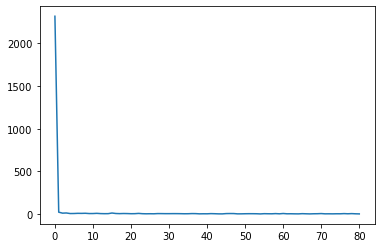

In [ ]:
plt.plot([i for i in range(NUM_EPOCHS)], train_loss)

### Let's use the trained model to find records with the greatest losses.

In [ ]:
evaluate = DataLoader(dataset, batch_size=1)

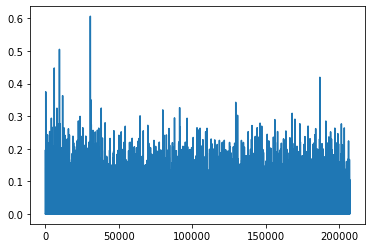

In [ ]:
item_losses = []
for item in evaluate:
        # clear the optimizer of previous gradients
        optimizer.zero_grad()
        # forward ---------------------------------------------
        output= otto(batch[1]) #batch is a list of three vectors: 
                # [y, cont_X, and cat_X]. We already converted categorical to continuous, so pass in batch[1]
        loss = criterion(output, batch[1])
        # backward --------------------------------------------
        loss.backward()
        optimizer.step()
        # append to the list of losses for each item
        item_losses.append(loss.item())
plt.plot([i for i in range(len(item_losses))], item_losses)

### Now `item_losses` can be a column in the aggregated dataset 
so we can attach the loss to the mmsi and date.

In [ ]:
len(item_losses)

207257

In [ ]:
aggs['autoencode_loss'] = item_losses

In [ ]:
aggs.columns

Index(['mmsi', 'dt', 'status', 'vesseltype', 'sog_mean', 'sog_min', 'sog_max',
       'sog_std', 'count', 'length', 'width', 'draft', 'vessel',
       'autoencode_loss'],
      dtype='object')

In [ ]:
aggs.sort_values('autoencode_loss', ascending=False).head()

,mmsi,dt,status,vesseltype,sog_mean,sog_min,sog_max,sog_std,count,length,width,draft,vessel,autoencode_loss
30582,338945000,2015-01-13 09:00:00,under way using engine,1018,6.10784,4.00000,9.00000,1.72335,51,86.14000,15.24000,0.00000,other,0.60678
30581,338945000,2015-01-13 08:00:00,under way using engine,1018,6.92703,1.80000,10.60000,2.27799,37,86.14000,15.24000,0.00000,other,0.57964
9543,303303000,2015-01-19 01:00:00,under way using engine,1001,0.04909,0.00000,0.90000,0.16429,55,36.28000,8.54000,0.00000,fishing,0.50519
9542,303303000,2015-01-19 00:00:00,under way using engine,1001,0.01667,0.00000,0.10000,0.03762,54,36.28000,8.54000,0.00000,fishing,0.50237
6023,303159000,2015-01-07 23:00:00,engaged in fishing,1001,0.00000,0.00000,0.00000,0.00000,53,39.93000,9.76000,0.00000,fishing,0.44794


In [ ]:
aggs['autoencode_loss'].describe()

count   207257.00000
mean         0.01271
std          0.02935
min          0.00011
25%          0.00036
50%          0.00130
75%          0.00892
max          0.60678
Name: autoencode_loss, dtype: float64

<AxesSubplot:ylabel='Frequency'>

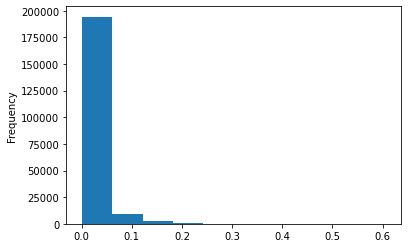

In [ ]:
aggs['autoencode_loss'].plot.hist()

In [ ]:
filt = aggs['autoencode_loss'] > 0.15
big_diffs = aggs[filt]

In [ ]:
big_diffs.shape

(1982, 14)

In [ ]:
big_diffs.to_csv('ais_autoencode_large_losses.csv', index=False)

In [ ]:
aggs.to_csv('ais_autoencode_all_losses.csv', index=False)

Restarted the kernel at some point and did not re-run the cells below because of time and already had the augmented tsne data file.

In [ ]:
tsne = TSNE().fit_transform(to.xs)

In [ ]:
tsne.shape

In [ ]:
tsne[:,0]

In [ ]:
sns.scatterplot(x=tsne[:,0], y=tsne[:,1])

In [ ]:
aggs['x'] = tsne[:,0]
aggs['y'] = tsne[:,1]

In [ ]:
aggs.head()

In [ ]:
aggs.to_csv('aggs_tsne.csv')